Q. The goal of this lab is to analyze a blog dataset by implementing K-Means clustering and deriving 3 insights from the data.

In [13]:
#Read data file function
def read_data(file_name):
    in_file = open(file_name, 'r')
    lines = in_file.readlines()
    col_names = lines[0].split('\t')
    rows = []
    row_names = []
    data = []
    for line in lines[1:]:
        rows = line.split('\t')
        row_names.append(rows[0])
        data.append([float(word) for word in rows[1:]])
    return row_names, col_names, data

In [21]:
from google.colab import files

# Upload the file
uploaded = files.upload()

# Display the uploaded files
for file_name in uploaded.keys():
    print(f"Uploaded file: {file_name}")


Saving Blog_Data.txt to Blog_Data (1).txt
Uploaded file: Blog_Data (1).txt


Cluster Assignments:

Cluster 1:
  - b'TOPBOTS'
  - b'Machine Learning Blog'
  - b'Machine Learning Mastery Blog  Machine Learning Mastery'
  - b'AI Trends'
  - b'Treehouse Blog'
  - b'Academic Computing'
  - b'Algorithmia Blog'
  - b'Basic Biology'
  - b'Astronomy Blogs  Sky & Telescope'
  - b'Blog  Machine Intelligence Research Institute'

Cluster 2:
  - b'An open mind'
  - b'teachcomputing.wordpress.com'

Cluster 3:
  - b''
  - b'TechCrunch'
  - b'Astronomy News'
  - b'Royal Society of Biology blog'
  - b'BMC blog networkBiology  BMC blog network'
  - b'ScienceBlogs'
  - b'MarsBlog.net'
  - b'Mashable'
  - b'Pharyngula'
  - b'Coding Horror'
  - b'Jason Ernst'
  - b'Lambda the Ultimate - Programming Languages Weblog'
  - b'Gdels Lost Letter and P=NP'

Cluster Mean Characteristics:
         scientists      show  education      where      past   release  \
Cluster                                                                   
0          0.300000  0.500000   0.000000   0.300000  0.2

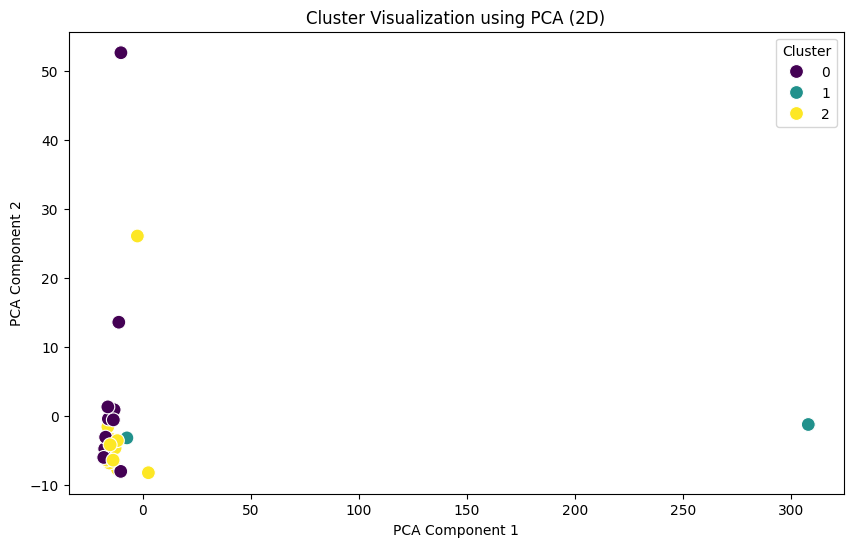

In [38]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA  # Import PCA

# Step 1: Load the data (assuming a tab-separated file with blog names and word frequencies)
def read_data(file_name):
    in_file = open(file_name, 'r')
    lines = in_file.readlines()
    col_names = lines[0].split('\t')  # Assuming the first line contains column names
    rows = []
    row_names = []

    data = []
    for line in lines[1:]:
        rows = line.split('\t')
        row_names.append(rows[0])  # Blog names
        data.append([int(word) for word in rows[1:]])  # Word frequency values as integers
    return row_names, col_names, data

# Step 2: Pearson similarity function
def pearson(v1, v2):
    sum1 = sum(v1)
    sum2 = sum(v2)
    sum1sq = sum([pow(v, 2) for v in v1])
    sum2sq = sum([pow(v, 2) for v in v2])
    products_sum = sum(v1[i] * v2[i] for i in range(len(v1)))
    num = products_sum - (sum1 * sum2 / len(v1))
    den = math.sqrt((sum1sq - pow(sum1, 2) / len(v1)) * (sum2sq - pow(sum2, 2) / len(v1)))
    if den == 0:
        return 0
    return 1.0 - num / den

# Step 3: K-Means clustering function
def kcluster(rows, distance=pearson, k=4):
    ranges = [(min([row[i] for row in rows]), max([row[i] for row in rows])) for i in range(len(rows[0]))]
    clusters = [[random.random() * (ranges[i][1] - ranges[i][0]) + ranges[i][0] for i in range(len(rows[0]))] for j in range(k)]
    lastmatches = None

    for t in range(100):  # Iterate for 100 steps

        bestmatches = [[] for i in range(k)]
        for j in range(len(rows)):  # For each row (blog)
            row = rows[j]
            bestmatch = 0
            for i in range(k):  # For each cluster
                d = distance(clusters[i], row)
                if d < distance(clusters[bestmatch], row):
                    bestmatch = i
            bestmatches[bestmatch].append(j)
        if bestmatches == lastmatches:
            break
        lastmatches = bestmatches
        for i in range(k):
            avgs = [0.0] * len(rows[0])
            if len(bestmatches[i]) > 0:
                for rowid in bestmatches[i]:
                    for m in range(len(rows[rowid])):
                        avgs[m] += rows[rowid][m]
                for j in range(len(avgs)):
                    avgs[j] /= len(bestmatches[i])
                clusters[i] = avgs
    return bestmatches

# Step 4: Load the dataset and apply clustering
blogs, words, data = read_data("Blog_Data.txt")
k = 3  # Set the number of clusters
answer = kcluster(data, k=k)

# Convert the data to a DataFrame for easier manipulation
data_df = pd.DataFrame(data, columns=words[1:])  # Use the words list as column headers

# Add clusters to the DataFrame
data_df['Cluster'] = -1  # Initialize clusters
cluster_results = {f"Cluster {i+1}": [] for i in range(k)}

for cluster_idx, cluster in enumerate(answer):
    for blog_idx in cluster:
        data_df.loc[blog_idx, 'Cluster'] = cluster_idx
        cluster_results[f"Cluster {cluster_idx+1}"].append(blogs[blog_idx])

# Step 5: Derive insights from the clusters
print("Cluster Assignments:")
for cluster_name, cluster_blogs in cluster_results.items():
    print(f"\n{cluster_name}:")
    for blog in cluster_blogs:
        print(f"  - {blog}")

# Calculate mean values for each cluster
cluster_means = data_df.groupby('Cluster').mean()
print("\nCluster Mean Characteristics:")
print(cluster_means)

# Derive insights
print("\nInsights:")
for cluster_idx, row in cluster_means.iterrows():
    print(f"\nCluster {cluster_idx+1}:")
    print(f"  - Most dominant word: {row.idxmax()} (Mean count: {row.max():.2f})")
    print(f"  - Least dominant word: {row.idxmin()} (Mean count: {row.min():.2f})")
    print(f"  - General trend: {'High frequency blogs' if row.mean() > 0.5 else 'Low frequency blogs'}")

# Step 6: Visualize the clusters using PCA
# Apply PCA to reduce the data to 2D for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_df[words[1:]])

# Add PCA components to the DataFrame
data_df['PCA1'] = pca_components[:, 0]
data_df['PCA2'] = pca_components[:, 1]

# Plot the clusters using the first two PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='viridis', data=data_df, s=100)
plt.title('Cluster Visualization using PCA (2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster")
plt.show()